<a href="https://colab.research.google.com/github/diogoscsilva/Recomendation/blob/main/Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%writefile kaggle.json
{"username":"<your kaggle username>","key":"<your kaggle api key>"}

Writing kaggle.json


In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=78b6ef1aa6850b430102683ab5354ca06d7c3ccc81aee2ef221c010b5fb30c75
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradatas

In [ ]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [02:59<00:00, 247.18it/s]

Moved 44441 images.


In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.18.0
Hub version: 0.16.1
GPU is available


In [ ]:
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

In [ ]:
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [ ]:
module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
module = hub.load(module_handle)

In [ ]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [ ]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [09:18<00:00,  8.95it/s]


In [ ]:
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


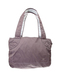

In [ ]:
test_img = '/content/Fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

In [ ]:
styles = pd.read_csv('/content/styles.csv', on_bad_lines='skip')
styles['id'] = styles['id'].astype('str')
styles.to_csv('/content/styles.csv', index=False)

In [ ]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [ ]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 1000
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [ ]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

5000it [00:23, 216.43it/s]


In [ ]:
t.build(trees)
t.save('t.ann')

True

In [ ]:
file_path = '/content/drive/MyDrive/ImgSim/'

In [ ]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

In [ ]:
from PIL import Image
import matplotlib.image as mpimg

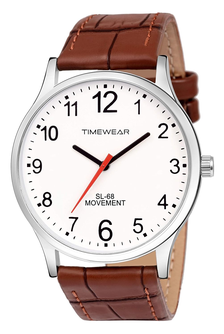

In [ ]:
img_addr = 'https://images-na.ssl-images-amazon.com/images/I/81%2Bd6eSA0eL._UL1500_.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.Resampling.LANCZOS)
img

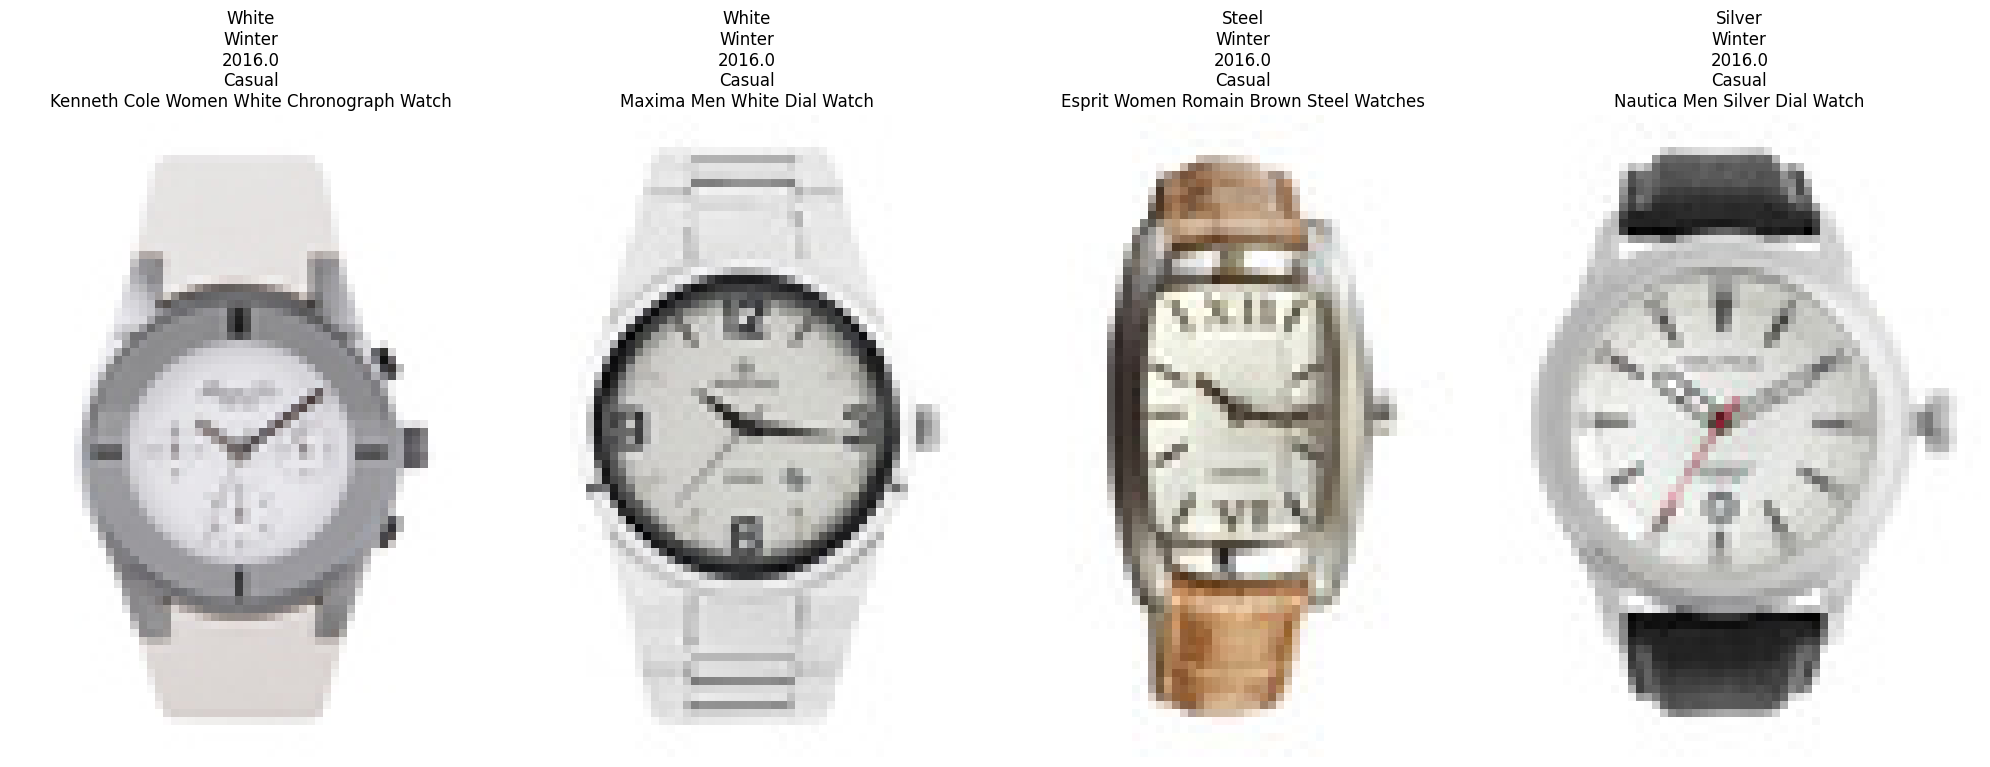

In [ ]:
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()